In [1]:
# default_exp pipeline
%load_ext autoreload
%autoreload 2

# pipeline


> API details.

In [2]:
#hide
from nbdev.showdoc import *

![pipeline](images/graphic9.PNG)

In [3]:
#export
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.data.external import *

from fastai.medical.imaging import PILBase
from fastai.medical.imaging import *
from fastai.vision.all import *

import pydicom
from PIL import Image

In [4]:
#export
dicom_windows = types.SimpleNamespace(
    abdomen_soft=(400,50),
    brain=(80,40),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    liver=(150,30),
    lungs=(1500,-600),
    mediastinum=(350,50),
    pe=(40,400),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    subdural=(254,100),
    stroke=(8,32)
)

I = (32-bit signed integer pixels)
F = (32-bit floating point pixels)
L = (8-bit pixels, black and white)

In [5]:
rsna_path = 'D:/Datasets/rsna_pulmonary'
rsna_items = get_dicom_files(rsna_path)
rsna_items

(#9) [Path('D:/Datasets/rsna_pulmonary/1 (1).dcm'),Path('D:/Datasets/rsna_pulmonary/10.dcm'),Path('D:/Datasets/rsna_pulmonary/11.dcm'),Path('D:/Datasets/rsna_pulmonary/12.dcm'),Path('D:/Datasets/rsna_pulmonary/13.dcm'),Path('D:/Datasets/rsna_pulmonary/14.dcm'),Path('D:/Datasets/rsna_pulmonary/15.dcm'),Path('D:/Datasets/rsna_pulmonary/16.dcm'),Path('D:/Datasets/rsna_pulmonary/17.dcm')]

Slight update to `scaled_px` to make it work better

In [6]:
def scaled_px(self):
    "`pixels` scaled by `RescaleSlope` and `RescaleIntercept`"
    img = self.pixels
    if hasattr(self, 'RescaleSlope') and hasattr(self, 'RescaleIntercept') is not None:
        return img * self.RescaleSlope + self.RescaleIntercept 
    else: return img

**unscaled uint8**

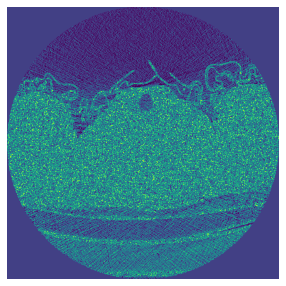

In [12]:
timage = np.array(rsna_items[0].dcmread().pixel_array)
timage = timage.astype(np.uint8)
show_image(timage, figsize=(5,5)); 

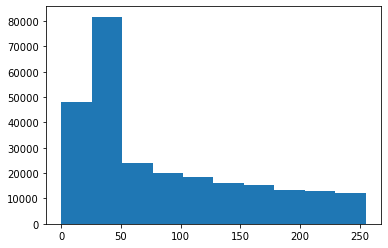

In [13]:
hist = plt.hist(timage.flatten())

**unscaled unit16**

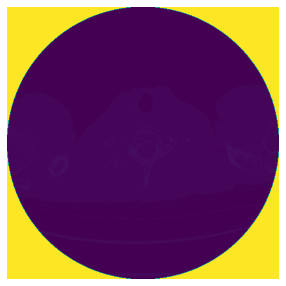

In [14]:
timage = np.array(rsna_items[0].dcmread().pixel_array)
timage = timage.astype(np.uint16)
show_image(timage, figsize=(5,5)); 

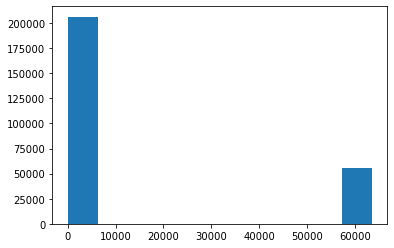

In [15]:
hist = plt.hist(timage.flatten())

**unscaled int8**

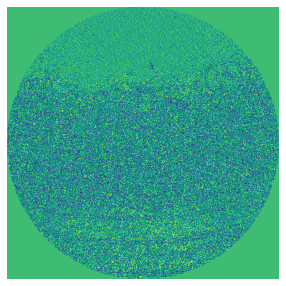

In [16]:
timage = np.array(rsna_items[0].dcmread().pixel_array)
timage = timage.astype(np.int8)
show_image(timage, figsize=(5,5));

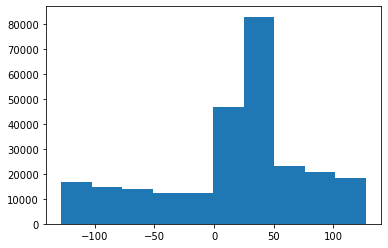

In [17]:
hist = plt.hist(timage.flatten())

**unscaled int16**

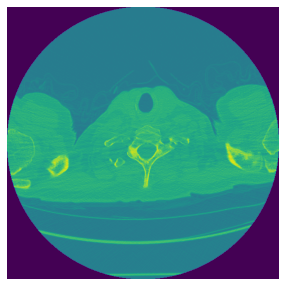

In [18]:
timage = np.array(rsna_items[0].dcmread().pixel_array)
timage = timage.astype(np.int16)
show_image(timage, figsize=(5,5));

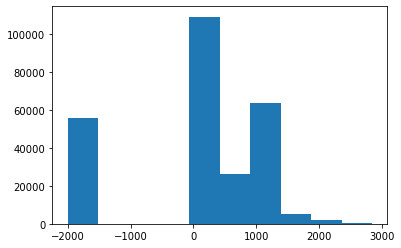

In [19]:
hist = plt.hist(timage.flatten())

`CustomPILDicom` is a customizable version of `PILDicom` that allows various parameters to be altered when creating the datablock

In [20]:
#export
class CustomPILDicom(PILDicom):
    @classmethod
    def create(cls, fn:(Path, str, bytes)):
        "Customizable mode, window_args, integer_args arguments for PILDicom "
        if isinstance(fn,bytes): im = pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn))
        if isinstance(fn,(Path,str)): im = pydicom.dcmread(fn)
        if window_args is not None: 
            scaled = np.array(im.windowed(*window_args).numpy())*h
        else:
            scaled = np.array(im.pixel_array).astype(integer_args)*h
        pill_im = Image.fromarray(scaled)
        return cls(pill_im.convert(mode))

In [21]:
show_doc(CustomPILDicom)

<h2 id="CustomPILDicom" class="doc_header"><code>class</code> <code>CustomPILDicom</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>CustomPILDicom</code>() :: `PILDicom`

This class represents an image object.  To create
:py:class:`~PIL.Image.Image` objects, use the appropriate factory
functions.  There's hardly ever any reason to call the Image constructor
directly.

* :py:func:`~PIL.Image.open`
* :py:func:`~PIL.Image.new`
* :py:func:`~PIL.Image.frombytes`

In [44]:
mode = 'L'; window_args = None; integer_args = np.uint16; h = 1

In [48]:
item_tfms = Resize(400)
batch_tfms = RandomResizedCropGPU(320)

set_seed(17)
rsna = DataBlock(blocks=(ImageBlock(cls=CustomPILDicom)),
                   get_items=get_dicom_files,
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)
dls = rsna.dataloaders(rsna_path, bs=5, num_workers=0)

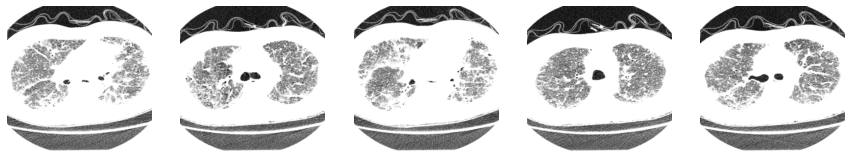

In [46]:
set_seed(17)
dls.show_batch(max_n=5, nrows=1)

In [47]:
mode = 'L'; window_args = None; integer_args = np.uint16; h = 255

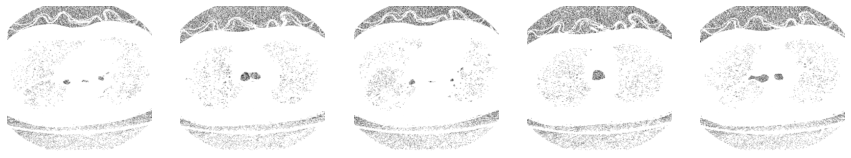

In [49]:
set_seed(17)
dls.show_batch(max_n=5, nrows=1)

In [28]:
mode = 'L'; window_args = dicom_windows.brain; integer_args = np.int16; h = 255

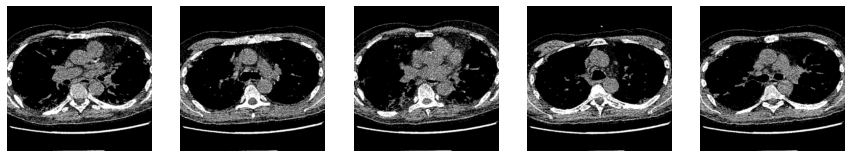

In [30]:
set_seed(17)
dls.show_batch(max_n=5, nrows=1)

In [31]:
mode = 'L'; window_args = dicom_windows.lungs; integer_args = np.int16; h = 255

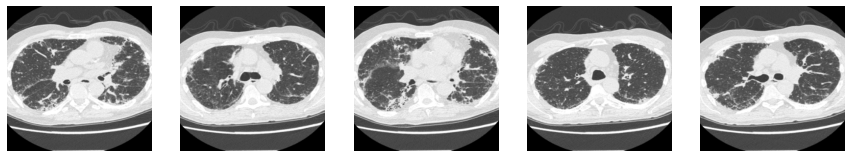

In [33]:
set_seed(17)
dls.show_batch(max_n=5, nrows=1)

In [34]:
mode = 'L'; _window_args = None; integer_args = np.int16; h = 1

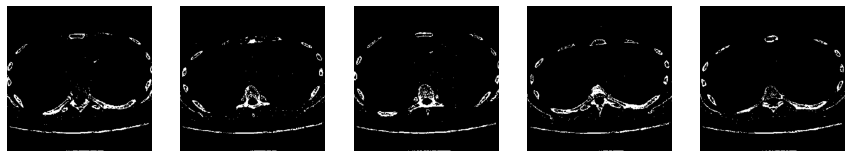

In [36]:
set_seed(17)
dls.show_batch(max_n=5, nrows=1)

In [72]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 02_explore.ipynb.
Converted 03_preprocessing.ipynb.
Converted 04_pipeline.ipynb.
Converted 05_train.ipynb.
Converted 06_examine.ipynb.
Converted 10_wearable.ipynb.
Converted 90_tutorial.ipynb.
Converted index.ipynb.
